In [1]:
import pandas as pd
from pathlib import Path
import torch
import sys
sys.path.append('src')

# from models.ae_kan import KANAutoencoder
from src.utils.new_preprocessing import preprocessing_dataset, simple_train_kan, change_hyperparam

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

print(f"Device : {device}")

GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Total memory: 8.0 GB
Memory available: 6.9 GB
Device : cuda


# Datasets import

In [2]:
data_dir = Path("data/processed/sectors")
sectors_list = [d.name for d in data_dir.iterdir() if d.is_dir() and d.name != 'unknown']

sector_log_returns = {}
for sector in sectors_list:
    returns_path = data_dir / sector / "log_returns.csv"
    df = pd.read_csv(returns_path, index_col=0)
    sector_log_returns[sector] = df.iloc[1:]  # Skip first row with NaN values

In [3]:
X_df = {}
W_df = {}
M_df = {}
data = {}

for sector in sector_log_returns:
    # Preprocess data for each sector
    X_df[sector], W_df[sector], M_df[sector] = preprocessing_dataset(
        log_returns_df=sector_log_returns[sector],
        win=60,
        min_periods=40,
        clip_val=3.0,
        min_valid_per_day=5,
        use_median=True,
        soft_weights=True
    )
    
    # Create tensors for each sector
    tensors = {
        'X': torch.tensor(X_df[sector].values, dtype=torch.float32),
        'W': torch.tensor(W_df[sector].values, dtype=torch.float32),
        'M': torch.tensor(M_df[sector].values, dtype=torch.float32)
    }

    # Split into train/test for each sector
    train_size = int(0.8 * len(tensors['X']))
    data[sector] = {
        'train': {
            'X': tensors['X'][:train_size],
            'W': tensors['W'][:train_size],
            'M': tensors['M'][:train_size]
        },
        'test': {
            'X': tensors['X'][train_size:],
            'W': tensors['W'][train_size:],
            'M': tensors['M'][train_size:]
        }
    }

print(f"\nSector: {sector}")
print(f"Train: {data[sector]['train']['X'].shape[0]} échantillons")
print(f"Test: {data[sector]['test']['X'].shape[0]} échantillons") 
print(f"Dates train: {X_df[sector].index[0]} à {X_df[sector].index[train_size-1]}")
print(f"Dates test: {X_df[sector].index[train_size]} à {X_df[sector].index[-1]}")


Sector: utilities
Train: 2987 échantillons
Test: 747 échantillons
Dates train: 2010-03-03 à 2022-01-10
Dates test: 2022-01-11 à 2024-12-31


In [4]:
data["utilities"]["train"]["X"]

tensor([[ 0.7095, -0.2273,  1.4788,  ...,  0.6971, -0.0319,  0.1895],
        [ 0.5891, -0.2844, -0.7470,  ..., -0.0982, -0.4259, -0.9280],
        [ 0.3553,  0.0000,  0.2215,  ...,  0.7744, -0.5840, -0.4092],
        ...,
        [-0.0682,  0.0000,  0.2831,  ...,  0.9535, -0.1712, -0.3092],
        [-0.2909,  1.1647, -0.8697,  ...,  0.6001,  0.0765,  0.1190],
        [-0.4511, -0.1024,  0.0603,  ..., -0.0457,  0.0000,  1.2413]])

# Training

In [11]:
from src.utils.new_preprocessing import hyperparameter_comparison

sector = "financials"

hyperparams = {
    'hidden_dims_choices': [32, 16],
    'latent_dims': 8,
    
    # BASIS
    'basis_types': 'spline',
    'M_values': 16,
    'poly_degrees': 3,
    'use_silu_choices': True,
    'dropout_rates': 0,
    
    # SKIP LINEAIRE
    'use_global_skip': True,
    'use_skip_choices': False,
    'skip_init_choices': 'identity',
    'skip_gain_values': 0.1,
    'max_skip_gain': 0.3,
    
    # REGULARISATION
    'lambda_alpha_values': 1e-3,
    'lambda_group_values': 1e-4,
    'lambda_tv_values': 1e-5,
    'lambda_poly_decay_values': 1e-6,
    'lambda_skip_l2_values': 1e-3,
    'lambda_reg_values': 1e-4,
    
    # LOSS
    'loss_types': 'huber',
    'huber_deltas': 1.0,
    
    # OPTIMISATION
    'batch_sizes': 64,
    'learning_rates': 0.0002,
    'weight_decays': 0.000001
}

In [ ]:
# simple_train_kan(sector, data[sector], hyperparams, epochs=150, save_results=True, plot_results=True, save_here="results/full_test_hp_regul")

🚀 Entraînement simple pour le secteur: communication_services
📊 Dimensions: Train torch.Size([2987, 17]), Test torch.Size([747, 17])

   - Architecture: 17 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 3.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3



KeyboardInterrupt: 

🔬 Comparaison hyperparamètre 'learning_rates' pour le secteur: communication_services
📋 Valeurs à tester: [0.0001, 0.0005, 0.001, 0.005]
⚙️ Epochs: 150
------------------------------------------------------------

🧪 Test 1/4: learning_rates = 0.0001
🚀 Entraînement simple pour le secteur: communication_services_learning_rates_0.0001
📊 Dimensions: Train torch.Size([2987, 17]), Test torch.Size([747, 17])

   - Architecture: 17 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 1.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3

📈 Epoch 1/150 | Train: 0.213990 | Val: 0.204250 ✅ | Reg: 0.046488 | LR: 1.00e-04
 

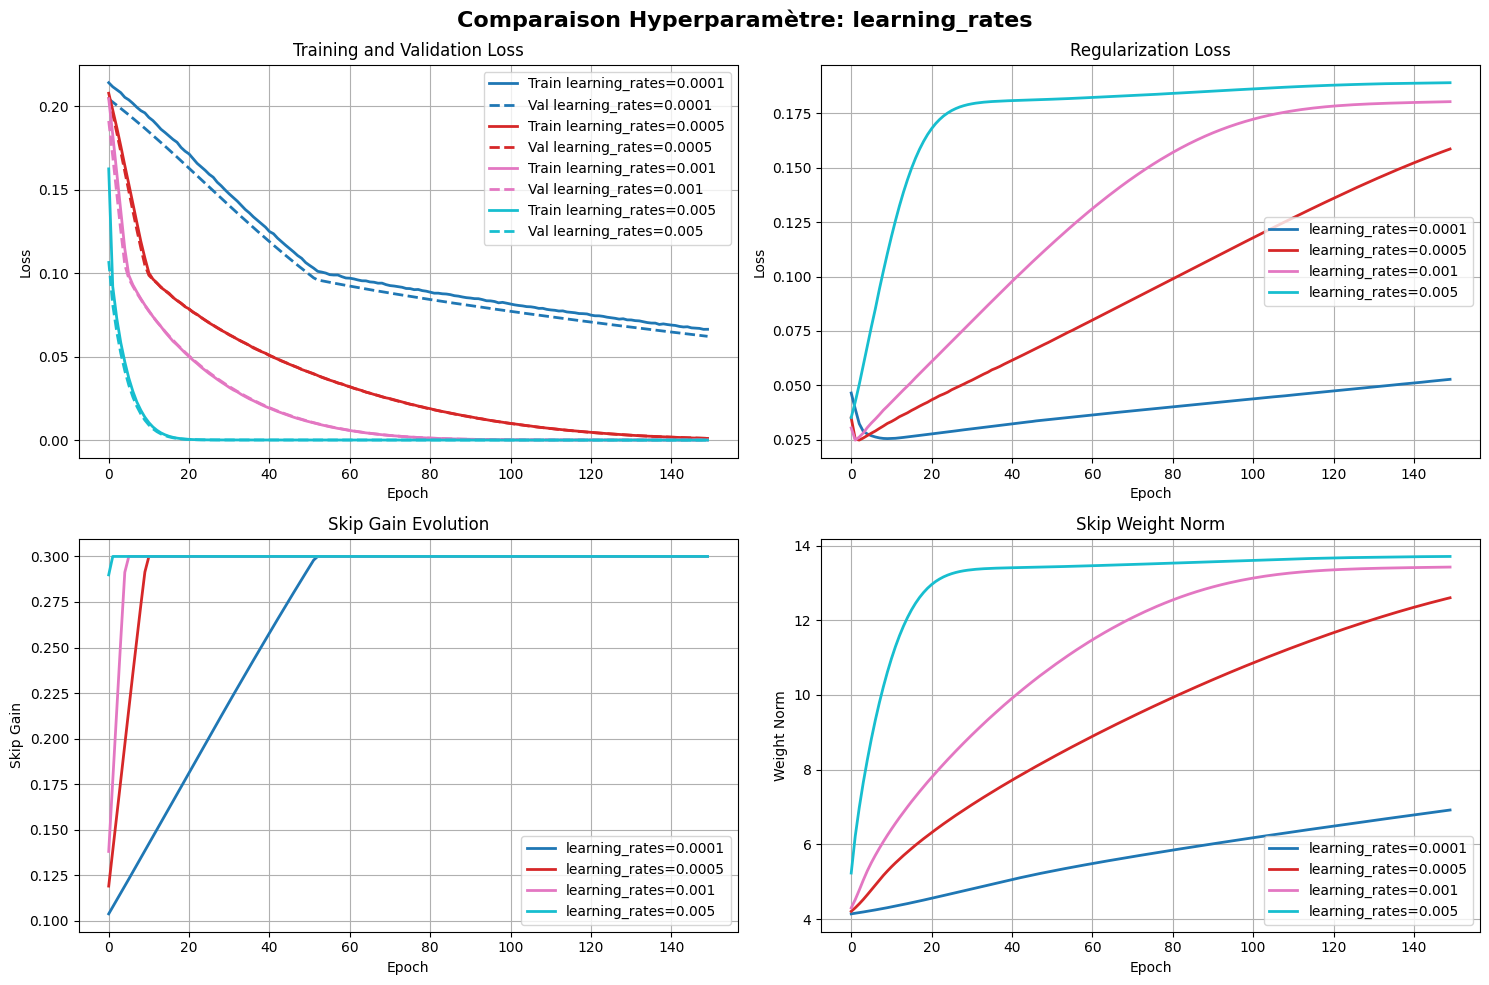


📋 RÉSUMÉ DE COMPARAISON - learning_rates
Valeur          Test Loss    Temps (s)    Epochs   Rang  
--------------------------------------------------------------------------------
0.005           0.000000     194.9        150      1     
0.001           0.000019     193.1        150      2     
0.0005          0.000885     185.7        150      3     
0.0001          0.064285     169.3        150      4     
--------------------------------------------------------------------------------
🏆 MEILLEUR: learning_rates = 0.005 (Loss: 0.000000)


In [9]:
hyperparameter = "learning_rates"
values_to_test = [1e-4, 5e-4, 1e-3, 5e-3]


results = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test=hyperparameter,
    values_to_test=values_to_test,
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

🔬 Comparaison hyperparamètre 'batch_sizes' pour le secteur: financials
📋 Valeurs à tester: [32, 64, 128, 256]
⚙️ Epochs: 150
------------------------------------------------------------

🧪 Test 1/4: batch_sizes = 32
🚀 Entraînement simple pour le secteur: financials_batch_sizes_32
📊 Dimensions: Train torch.Size([2987, 64]), Test torch.Size([747, 64])

   - Architecture: 64 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   - Batch size: 32
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3

📈 Epoch 1/150 | Train: 0.159917 | Val: 0.156389 ✅ | Reg: 0.116209 | LR: 2.00e-04
   ↳ skip_gain=0.1150 | ||W_skip||=8.1341
📈 Epoch 2/15

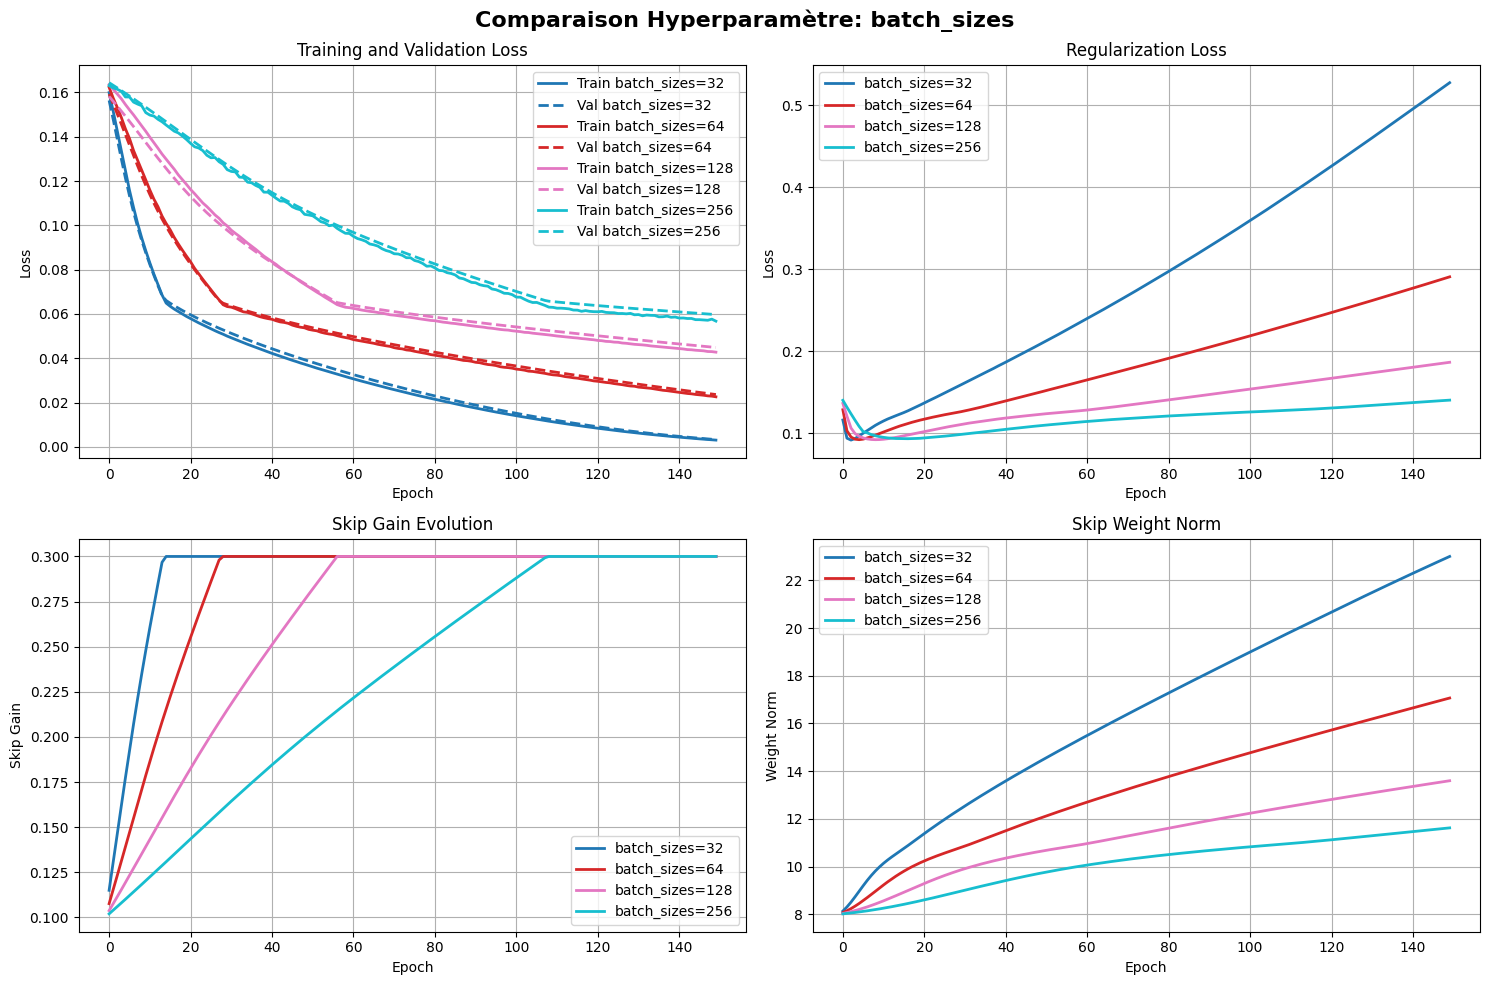


📋 RÉSUMÉ DE COMPARAISON - batch_sizes
Valeur          Test Loss    Temps (s)    Epochs   Rang  
--------------------------------------------------------------------------------
32              0.003308     285.9        150      1     
64              0.024659     144.8        150      2     
128             0.046677     81.5         150      3     
256             0.061838     50.8         150      4     
--------------------------------------------------------------------------------
🏆 MEILLEUR: batch_sizes = 32 (Loss: 0.003308)
🔬 Comparaison hyperparamètre 'weight_decays' pour le secteur: financials
📋 Valeurs à tester: [1e-06, 0.0001, 0.01]
⚙️ Epochs: 150
------------------------------------------------------------

🧪 Test 1/3: weight_decays = 1e-06
🚀 Entraînement simple pour le secteur: financials_weight_decays_1e-06
📊 Dimensions: Train torch.Size([2987, 64]), Test torch.Size([747, 64])

   - Architecture: 64 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   -

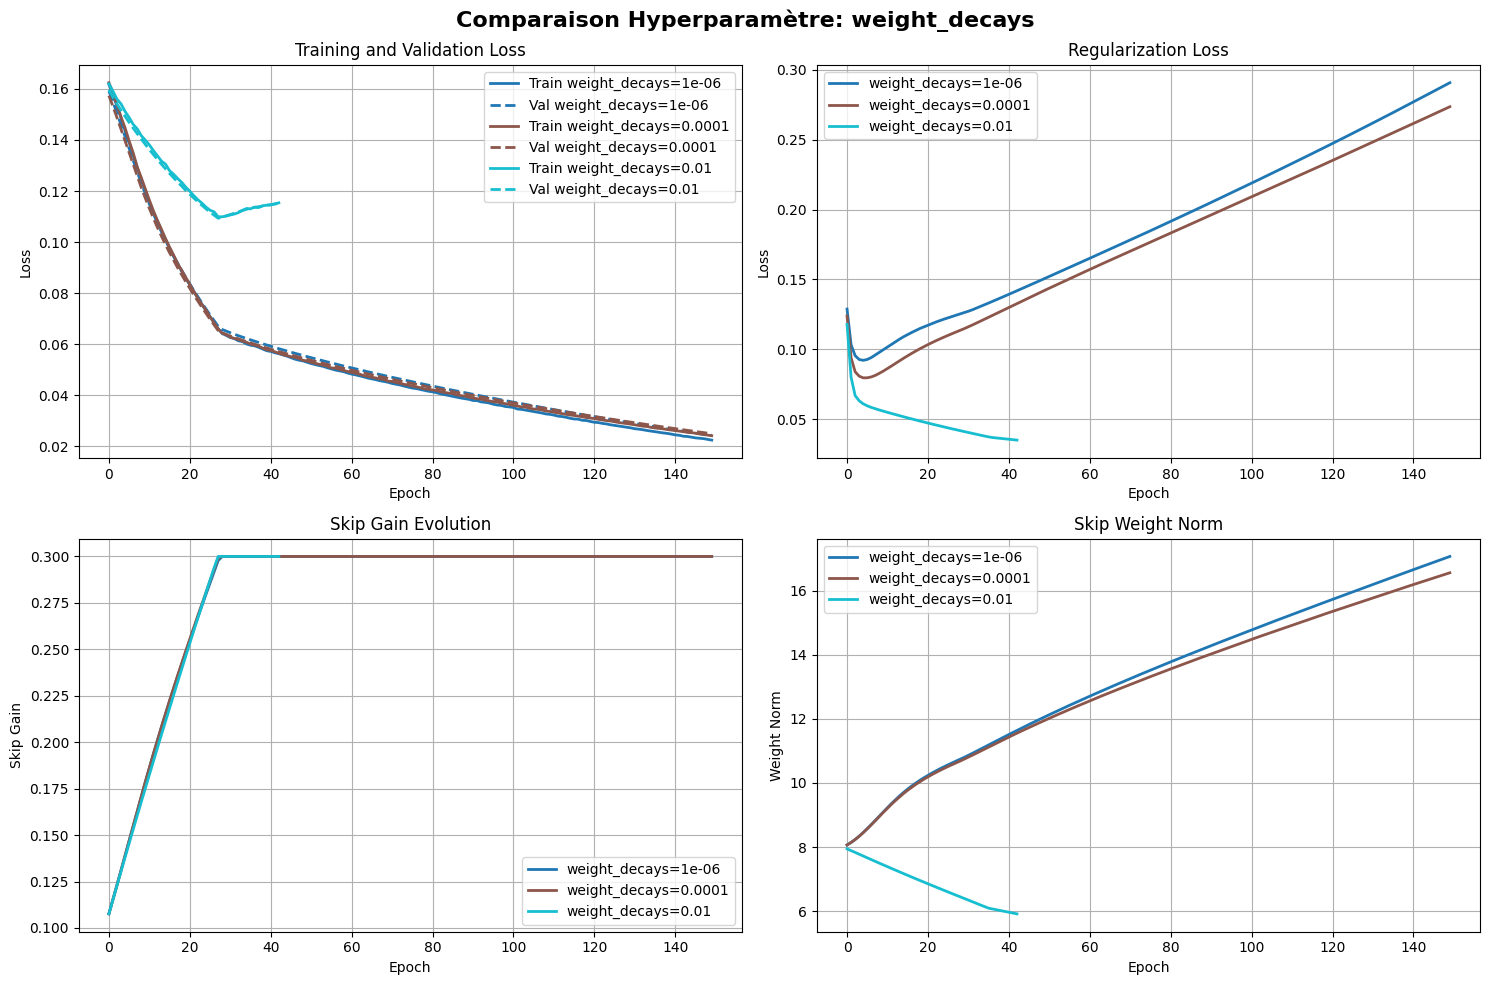


📋 RÉSUMÉ DE COMPARAISON - weight_decays
Valeur          Test Loss    Temps (s)    Epochs   Rang  
--------------------------------------------------------------------------------
1e-06           0.024775     164.6        150      1     
0.0001          0.026302     171.0        150      2     
0.01            0.118844     49.0         43       3     
--------------------------------------------------------------------------------
🏆 MEILLEUR: weight_decays = 1e-06 (Loss: 0.024775)


In [12]:
results_batch = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="batch_sizes",
    values_to_test=[32, 64, 128, 256],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

results_lr = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="weight_decays",
    values_to_test=[1e-6, 1e-4, 1e-2],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)


In [ ]:
results_hidden = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="hidden_dims_choices",
    values_to_test=[[16, 8], [32, 16], [64, 32], [32, 16, 8]],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

results_basis = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="basis_types",
    values_to_test=["spline", "poly"],
    epochs=100,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

🔬 Comparaison hyperparamètre 'hidden_dims_choices' pour le secteur: financials
📋 Valeurs à tester: [[16, 8], [32, 16], [64, 32], [32, 16, 8]]
⚙️ Epochs: 150
------------------------------------------------------------

🧪 Test 1/4: hidden_dims_choices = [16, 8]
🚀 Entraînement simple pour le secteur: financials_hidden_dims_choices_[16, 8]
📊 Dimensions: Train torch.Size([2987, 64]), Test torch.Size([747, 64])

   - Architecture: 64 → [16, 8] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: identity
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3

📈 Epoch 1/150 | Train: 0.163409 | Val: 0.154792 ✅ | Reg: 0.093778 | LR: 2.00e-

KeyboardInterrupt: 

In [ ]:

# Test different skip gains
results_skip = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams, 
    hp_to_test="skip_gain_values",
    values_to_test=[0.1, 0.5, 1.0, 2.0],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

# Test different max skip gains
results_max_skip = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="max_skip_gain",
    values_to_test=[0.1, 0.5, 0.7, 0.9, 1.0, 1.5, 2.0, 5],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)



# Test different dropout rates
results_dropout = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="dropout_rates",
    values_to_test=[0.0, 0.1, 0.3, 0.5],
    epochs=150, 
    save_results=True,
    save_here="results/hyperparams_comparison"
)

In [ ]:
# Test different skip types
results_skip_types = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="skip_init_choices",
    values_to_test=["zero", "identity", "xavier"],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

🔬 Comparaison hyperparamètre 'skip_init_choices' pour le secteur: financials
📋 Valeurs à tester: ['zero', 'identity', 'xavier']
⚙️ Epochs: 150
------------------------------------------------------------

🧪 Test 1/3: skip_init_choices = zero
🚀 Entraînement simple pour le secteur: financials_skip_init_choices_zero
📊 Dimensions: Train torch.Size([2987, 64]), Test torch.Size([747, 64])

   - Architecture: 64 → [32, 16] → 8
   - Basis: spline, M: 16
   - Learning rate: 2.0e-04
   - Batch size: 64
   - Dropout: 0
   - Use SiLU: True
   - Skip connections: False
   - Skip init: zero
   - Skip gain: 0.1
   - Max skip gain: 0.3
   - Global skip: True
   - Loss type: huber
   - Huber delta: 1.0
   - Weight decay: 1e-06
   - Lambda reg: 0.0001
   - Lambda alpha: 0.001
   - Lambda group: 0.0001
   - Lambda TV: 1e-05
   - Lambda poly decay: 1e-06
   - Lambda skip L2: 0.001
   - Poly degree: 3

📈 Epoch 1/150 | Train: 0.197228 | Val: 0.195849 ✅ | Reg: 0.127200 | LR: 2.00e-04
   ↳ skip_gain=0.0931 | 

In [ ]:
# Test lambda_alpha
results_lambda_alpha = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_alpha_values", 
    values_to_test=[1e-4, 1e-3, 1e-2],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

# Test lambda_group
results_lambda_group = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_group_values",
    values_to_test=[1e-5, 1e-4, 1e-3],
    epochs=150,
    save_results=True, 
    save_here="results/hyperparams_comparison"
)

# Test lambda_tv
results_lambda_tv = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_tv_values",
    values_to_test=[1e-6, 1e-5, 1e-4],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

# Test lambda_poly_decay
results_lambda_poly = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_poly_decay_values",
    values_to_test=[1e-7, 1e-6, 1e-5, 1e-3],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

# Test lambda_skip_l2
results_lambda_skip = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_skip_l2_values",
    values_to_test=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)

# Test lambda_reg
results_lambda_reg = hyperparameter_comparison(
    sector_name=sector,
    sector_data=data[sector],
    base_hyperparams=hyperparams,
    hp_to_test="lambda_reg_values",
    values_to_test=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    epochs=150,
    save_results=True,
    save_here="results/hyperparams_comparison"
)


# Train all sectors

In [ ]:
change_hyperparam(hyperparams, "batch_sizes", 128)

for sector in sectors_list:
    simple_train_kan(sector, data[sector], hyperparams, epochs=150, save_results=True, plot_results=True, save_here="results/full_test_hp_regul")
    break